Run fast simulations
================

In this section, we will learn how to:

- run timeseries simulations with "fast" mode and using the ``PVEngine``
- run timeseries simulations with "fast" mode and using the ``run_timeseries_engine()`` function

**Note:** we recommend using the "full" mode instead, because it is more accurate and it's about the same run time. See previous tutorials on full mode simulations.

Imports and settings

In [1]:
# Import external libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)
warnings.filterwarnings('ignore')
# Paths
LOCAL_DIR = os.getcwd()
DATA_DIR = os.path.join(LOCAL_DIR, 'data')
filepath = os.path.join(DATA_DIR, 'test_df_inputs_MET_clearsky_tucson.csv')

## Overview of "fast" mode

The fast mode simulation was first introduced in pvfactors v1.0.2. It relies on a mathematical simplification (see Theory section of the documentation) of the problem that assumes that we already know the irradiance incident on all front PV row surfaces and ground surfaces (for instance using the Perez model). In this mode, we therefore only calculate view factors from PV row back surfaces to the other ones assuming that back surfaces don't see each other. This way we do not need to solve a linear system of equations anymore for "ordered" PV arrays.  

This is an approximation compared to the "full" mode, since we're not calculating the impact of the multiple reflections on the PV array surfaces. But the initial results show that it still provides a very reasonable estimate of back surface incident irradiance values.

## Get timeseries inputs

In [2]:
def import_data(fp):
    """Import 8760 data to run pvfactors simulation"""
    tz = 'US/Arizona'
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.DatetimeIndex(df.index).tz_convert(tz)
    return df

df = import_data(filepath)
df_inputs = df.iloc[:24, :]

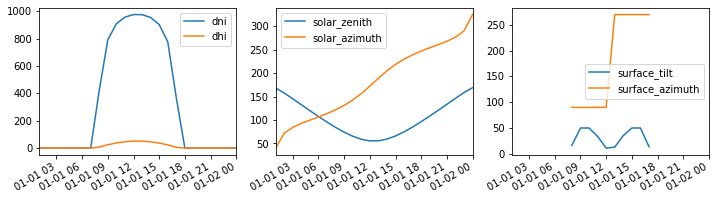

In [3]:
# Plot the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
df_inputs[['dni', 'dhi']].plot(ax=ax1)
df_inputs[['solar_zenith', 'solar_azimuth']].plot(ax=ax2)
df_inputs[['surface_tilt', 'surface_azimuth']].plot(ax=ax3)
plt.show()

In [4]:
# Use a fixed albedo
albedo = 0.2

## Prepare PV array parameters

In [5]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
}

## Run "fast" simulations with the PVEngine

The ``PVEngine`` can be used to easily run fast mode simulations, using its ``run_fast_mode()`` method.  
In order to run the fast mode, the users need to specify which PV row to look at for calculating back surface incident irradiance. The way this is done is by specifying the index of the PV row either at initialiatization, or in the ``run_fast_mode()`` method.  
Optionally, a specific segment index can also be passed to the PV Engine to calculate the irradiance only for a segment of a PV row's back surface.

In [6]:
# Import PVEngine and OrderedPVArray
from pvfactors.engine import PVEngine
from pvfactors.geometry import OrderedPVArray

# Instantiate PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)
# Create PV engine, and specify the index of the PV row for fast mode
fast_mode_pvrow_index = 1  # look at the middle PV row
eng = PVEngine(pvarray, fast_mode_pvrow_index=fast_mode_pvrow_index)

# Fit PV engine to the timeseries data
eng.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
        df_inputs.solar_zenith, df_inputs.solar_azimuth, 
        df_inputs.surface_tilt, df_inputs.surface_azimuth,
        albedo)

A report function needs to be passed to the ``run_fast_mode()`` method in order to return calculated values.  
The report function will need to rely on the pvarray's ``ts_pvrows`` attribute in order to get the calculated outputs.

In [7]:
# Create a function to build the report: the function will get the total incident irradiance on the back
# of the middle PV row
def fn_report(pvarray): return {'total_inc_back': (pvarray.ts_pvrows[fast_mode_pvrow_index]
                                                  .back.list_segments[0].get_param_weighted('qinc'))}

In [8]:
# Run timeseries simulations
report = eng.run_fast_mode(fn_build_report=fn_report)

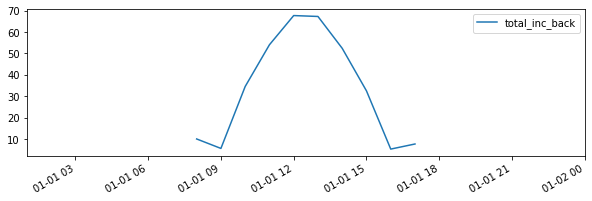

In [9]:
# make a dataframe out of the report
df_report = pd.DataFrame(report, index=df_inputs.index)

# and plot the results
f, ax = plt.subplots(figsize=(10, 3))
df_report.plot(ax=ax)
plt.show()

## Run "fast" simulations using ``run_timeseries_engine()``

The same thing can be done more rapidly using the ``run_timeseries_engine()`` function.

In [10]:
# Choose center row (index 1) for the fast simulation
fast_mode_pvrow_index = 1

In [11]:
# Create a function to build the report: the function will get the total incident irradiance on the back
# of the middle PV row
def fn_report(pvarray): return {'total_inc_back': (pvarray.ts_pvrows[fast_mode_pvrow_index]
                                                  .back.list_segments[0].get_param_weighted('qinc'))}

In [12]:
# import function to run simulations in parallel
from pvfactors.run import run_timeseries_engine

# run simulations
report = run_timeseries_engine(
    fn_report, pvarray_parameters, df_inputs.index, 
    df_inputs.dni, df_inputs.dhi, 
    df_inputs.solar_zenith, df_inputs.solar_azimuth, 
    df_inputs.surface_tilt, df_inputs.surface_azimuth, albedo,
    fast_mode_pvrow_index=fast_mode_pvrow_index)  # this will trigger fast mode calculation

# make a dataframe out of the report
df_report = pd.DataFrame(report, index=df_inputs.index)

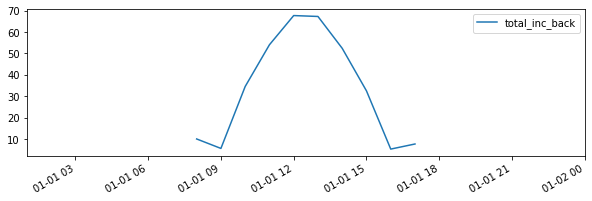

In [13]:
f, ax = plt.subplots(figsize=(10, 3))
df_report.plot(ax=ax)
plt.show()

The results obtained are strictly identical to when the ``PVEngine`` was used, but it takes a little less code to run a simulation.